In [112]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle
import warnings

from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, Column, vstack, join

import numpy as np 
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import rcParams

from dsigma.jackknife import add_continous_fields
from dsigma.jackknife import jackknife_resampling
from dsigma.jackknife import jackknife_field_centers, add_jackknife_fields

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import jianbing

from jianbing import visual
from jianbing import prepare
from jianbing import catalog
from jianbing import scatter
from jianbing import wlensing

In [5]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

In [7]:
des_dir = os.path.join(jianbing.JB_DIR, 'data', 'des')

In [137]:
sim_dsig = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))

### HSC lensing pre-compute

#### DES lensing results from Chang et al. (2018)

In [10]:
# Lensing data using medium photo-z quality cut
lensing = os.path.join(data_dir, 's16a_weak_lensing_medium_comoving.hdf5')

# Random
rand = Table.read(lensing, path='random')

# Pre-compute
precompute = os.path.join(data_dir, 's16a_weak_lensing_medium_comoving_precompute.hdf5')

In [11]:
redm_sdss = Table.read(precompute, path='redm_sdss_specz')

redm_hsc = Table.read(precompute, path='redm_hsc_specz')

In [12]:
# DES fiducial profile: 20 < lambda < 100; 0.2 < z < 0.55
# From Chang et al. 2018 (Fig 3)
# h=0.7; comoving; median z = 0.41
# R_comoving = (1+z) * R_physical

des_dsig = Table.read(os.path.join(des_dir, 'y1_DeltaSigma_metacal_unblind.txt'), format='ascii')

In [13]:
mask_sdss = (
    (redm_sdss['z'] >= 0.2) & (redm_sdss['z'] <= 0.55) &
    (redm_sdss['lambda_cluster_redm'] >= 20)
)

dsig_sdss = wlensing.batch_dsigma_profiles(
    redm_sdss, rand, [mask_sdss], n_rand=100000, n_boot=500,
    n_jk=45, verbose=True, n_jobs=None)

There are 480 objects in sample 1


In [14]:
mask_hsc = (
    (redm_hsc['z'] >= 0.2) & (redm_hsc['z'] <= 0.55) &
    (redm_hsc['lambda'] >= 20)
)

dsig_hsc = wlensing.batch_dsigma_profiles(
    redm_hsc, rand, [mask_hsc], n_rand=100000, n_boot=500,
    n_jk=45, verbose=True, n_jobs=None)

There are 285 objects in sample 1


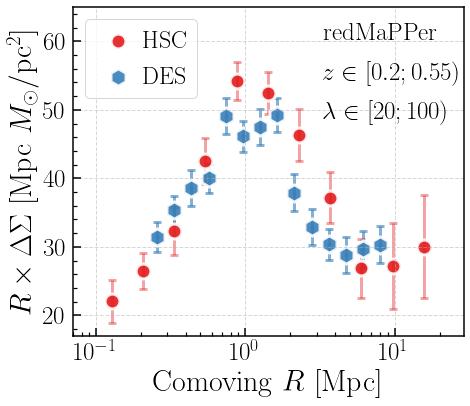

In [73]:
fig = plt.figure(figsize=(6.5, 5.5))
fig.subplots_adjust(left=0.155, right=0.99, bottom=0.16, top=0.99,
                    wspace=0.3, hspace=0.0)

# ---- R x DeltaSigma ---- #
ax2 = fig.add_subplot(111)
ax2.set_xscale("log", nonpositive='clip')

# HSC profile
ax2.errorbar(
    dsig_hsc.meta['r_mpc'], dsig_hsc.meta['r_mpc'] * dsig_hsc[0]['dsigma'], 
    yerr=(dsig_hsc.meta['r_mpc'] * dsig_hsc[0]['dsig_err_jk']),
    ecolor="#e41a1c", color="None", alpha=0.4, capsize=4, capthick=3.0, elinewidth=3.0, 
    label='__no_label__', fmt='.', zorder=0)
ax2.scatter(
    dsig_hsc.meta['r_mpc'], dsig_hsc.meta['r_mpc'] * dsig_hsc[0]['dsigma'], s=220, alpha=0.9, 
    facecolor="#e41a1c", edgecolor='w', label=r'$\rm HSC$', linewidth=3)

# DES Profile
ax2.errorbar(
    des_dsig['col1'],  des_dsig['col1'] * des_dsig['col2'], 
    yerr=(des_dsig['col1'] * des_dsig['col3']),
    ecolor="#377eb8", color="#377eb8", alpha=0.6, capsize=4, capthick=3.0, elinewidth=3.0, 
    label='__no_label__', fmt='.', zorder=0)
ax2.scatter(
    des_dsig['col1'] , des_dsig['col1'] * des_dsig['col2'], s=300, alpha=0.9, 
    marker='h', facecolor="#377eb8", edgecolor='w', label=r'$\rm DES$', linewidth=3)

ax2.legend(loc='upper left', fontsize=24, handletextpad=0.02)

ax2.text(0.64, 0.90, r'$\rm redMaPPer$', transform=ax2.transAxes, fontsize=25)
ax2.text(0.64, 0.78, r'$z\in [0.2; 0.55)$', transform=ax2.transAxes, fontsize=25)
ax2.text(0.64, 0.66, r'$\lambda \in [20; 100)$', transform=ax2.transAxes, fontsize=25)

_ = ax2.set_xlim(0.07, 29)
_ = ax2.set_ylim(17, 65)

_ = ax2.set_xlabel(r'${\rm Comoving}\ R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=30)

In [74]:
fig.savefig(os.path.join(fig_dir, 'fig_G1.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_G1.pdf'), dpi=120)

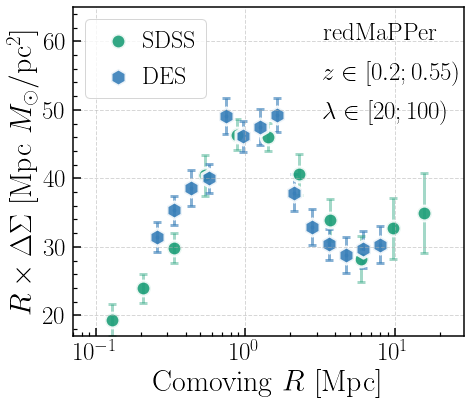

In [76]:
fig = plt.figure(figsize=(6.5, 5.5))
fig.subplots_adjust(left=0.155, right=0.99, bottom=0.16, top=0.99,
                    wspace=0.3, hspace=0.0)

# ---- R x DeltaSigma ---- #
ax2 = fig.add_subplot(111)
ax2.set_xscale("log", nonpositive='clip')

# sdss profile
ax2.errorbar(
    dsig_sdss.meta['r_mpc'], dsig_sdss.meta['r_mpc'] * dsig_sdss[0]['dsigma'], 
    yerr=(dsig_sdss.meta['r_mpc'] * dsig_sdss[0]['dsig_err_jk']),
    ecolor="#1b9e77", color="None", alpha=0.4, capsize=4, capthick=3.0, elinewidth=3.0, 
    label='__no_label__', fmt='.', zorder=0)
ax2.scatter(
    dsig_sdss.meta['r_mpc'], dsig_sdss.meta['r_mpc'] * dsig_sdss[0]['dsigma'], s=220, alpha=0.9, 
    facecolor="#1b9e77", edgecolor='w', label=r'$\rm SDSS$', linewidth=3)

# DES Profile
ax2.errorbar(
    des_dsig['col1'],  des_dsig['col1'] * des_dsig['col2'], 
    yerr=(des_dsig['col1'] * des_dsig['col3']),
    ecolor="#377eb8", color="#377eb8", alpha=0.6, capsize=4, capthick=3.0, elinewidth=3.0, 
    label='__no_label__', fmt='.', zorder=0)
ax2.scatter(
    des_dsig['col1'] , des_dsig['col1'] * des_dsig['col2'], s=300, alpha=0.9, 
    marker='h', facecolor="#377eb8", edgecolor='w', label=r'$\rm DES$', linewidth=3)

ax2.legend(loc='upper left', fontsize=24, handletextpad=0.02)

ax2.text(0.64, 0.90, r'$\rm redMaPPer$', transform=ax2.transAxes, fontsize=25)
ax2.text(0.64, 0.78, r'$z\in [0.2; 0.55)$', transform=ax2.transAxes, fontsize=25)
ax2.text(0.64, 0.66, r'$\lambda \in [20; 100)$', transform=ax2.transAxes, fontsize=25)

_ = ax2.set_xlim(0.07, 29)
_ = ax2.set_ylim(17, 65)

_ = ax2.set_xlabel(r'${\rm Comoving}\ R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(
    r'$R \times \Delta\Sigma\ [{\rm Mpc}\ M_{\odot}/\mathrm{pc}^2]$', fontsize=30)

#### DES lensing from McClintock et al. (2018)

In [78]:
# Lensing data using medium photo-z quality cut
lensing = os.path.join(data_dir, 's16a_weak_lensing_medium_larger.hdf5')

# Random
rand = Table.read(lensing, path='random')

# Pre-compute
precompute = os.path.join(data_dir, 's16a_weak_lensing_medium_larger_precompute.hdf5')

redm_sdss = Table.read(precompute, path='redm_sdss_specz')

redm_hsc = Table.read(precompute, path='redm_hsc_specz')

In [94]:
des_dir = '/Users/song/Downloads/all_profiles/'

In [219]:
des_sum = {}

#### 5 < lambda < 10

# 0.20 < z < 0.35
# The S/N of the DES DSigma profile is  35.31
# There are 624 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  28.34

# 0.35 < z < 0.50
# The S/N of the DES DSigma profile is  28.98
# There are 1048 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  21.19


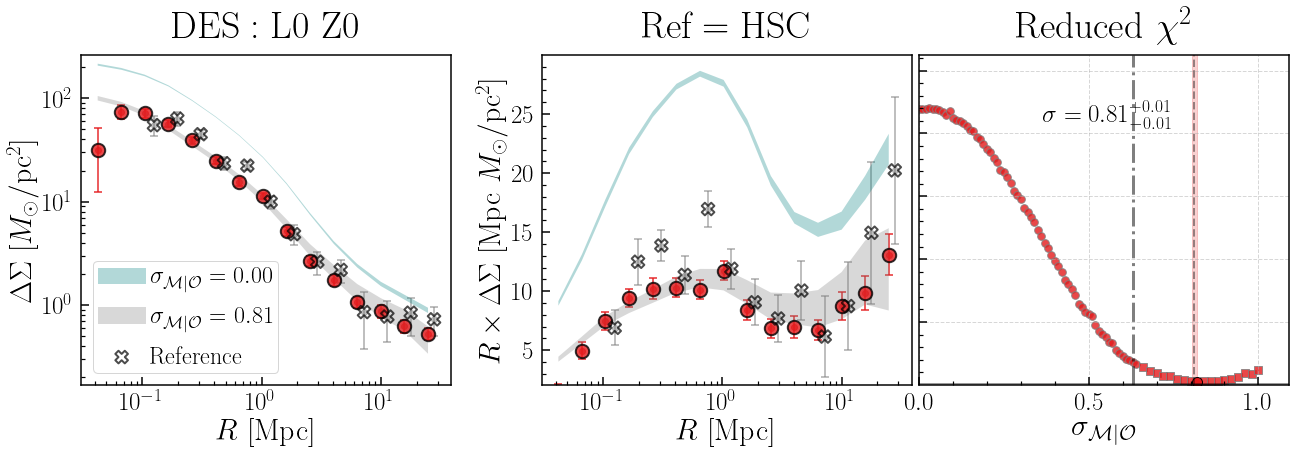

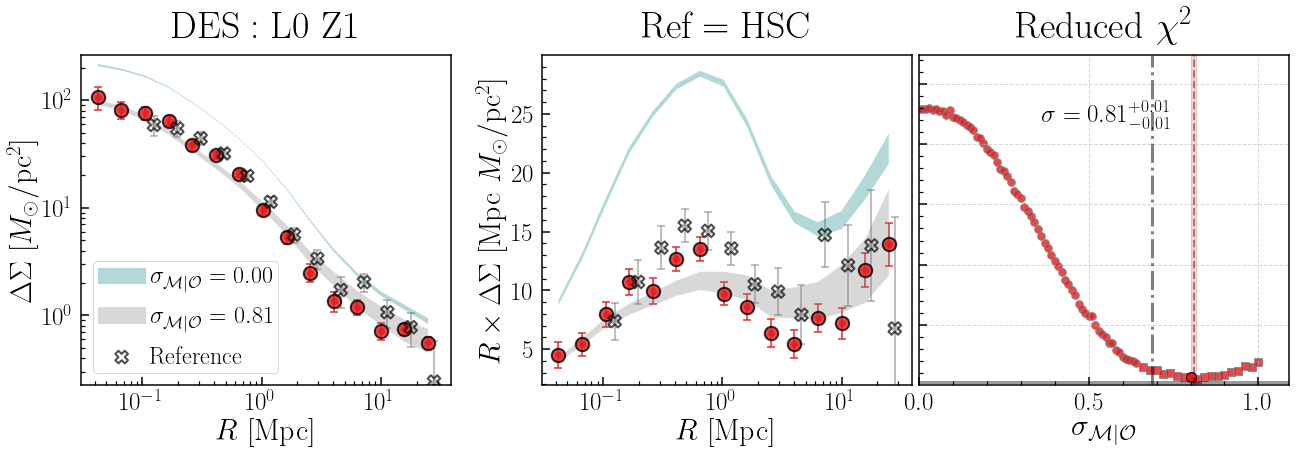

In [221]:
print("# 0.20 < z < 0.35")
des_l0_z0, hsc_l0_z0, fig = prepare_des_dsig(
    'l0_z0', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=45, p_cen=0.0)

print("\n# 0.35 < z < 0.50")
des_l0_z1, hsc_l0_z1, fig = prepare_des_dsig(
    'l0_z1', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=45, p_cen=0.0)

des_sum['des_l0_z0'] = des_l0_z0
des_sum['des_l0_z1'] = des_l0_z1
des_sum['hsc_l0_z0'] = hsc_l0_z0
des_sum['hsc_l0_z1'] = hsc_l0_z1

#### 10 < lambda < 14

# 0.20 < z < 0.35
# The S/N of the DES DSigma profile is  32.04
# There are 146 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  28.29

# 0.35 < z < 0.50
# The S/N of the DES DSigma profile is  26.84
# There are 212 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  19.14


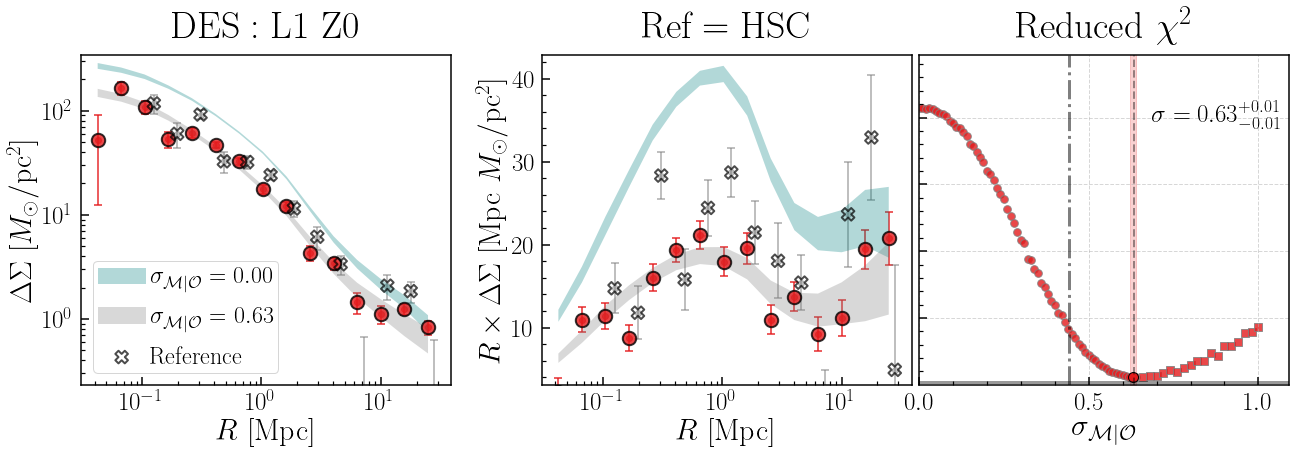

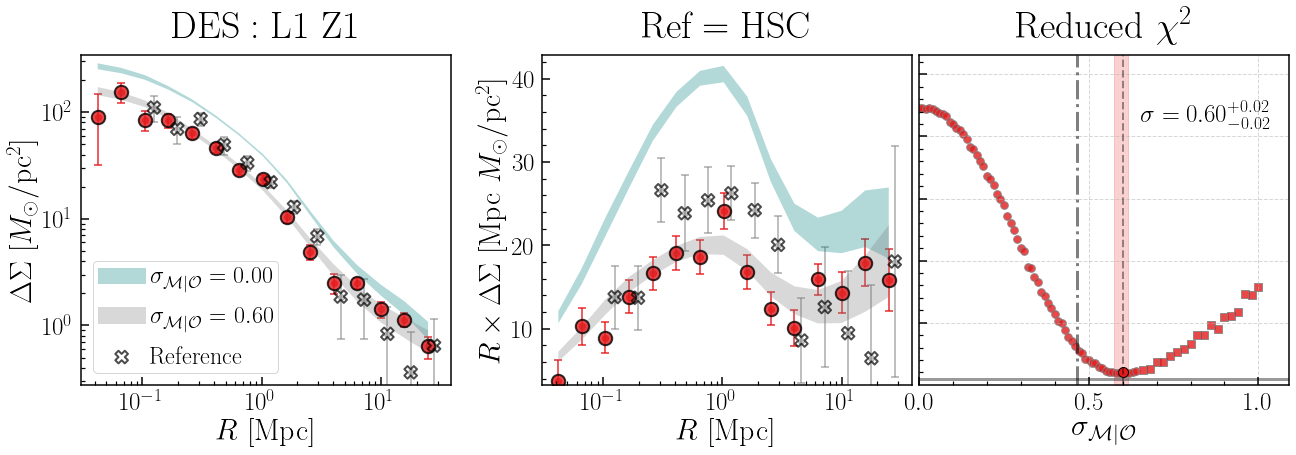

In [224]:
print("# 0.20 < z < 0.35")
des_l1_z0, hsc_l1_z0, fig = prepare_des_dsig(
    'l1_z0', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=45, p_cen=0.3)

print("\n# 0.35 < z < 0.50")
des_l1_z1, hsc_l1_z1, fig = prepare_des_dsig(
    'l1_z1', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=45, p_cen=0.3)

des_sum['des_l1_z0'] = des_l1_z0
des_sum['des_l1_z1'] = des_l1_z1
des_sum['hsc_l1_z0'] = hsc_l1_z0
des_sum['hsc_l1_z1'] = hsc_l1_z1

#### 14 < lambda < 20

# 0.20 < z < 0.35
# The S/N of the DES DSigma profile is  33.11
# There are 91 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  23.75

# 0.35 < z < 0.50
# The S/N of the DES DSigma profile is  27.48
# There are 144 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  20.03


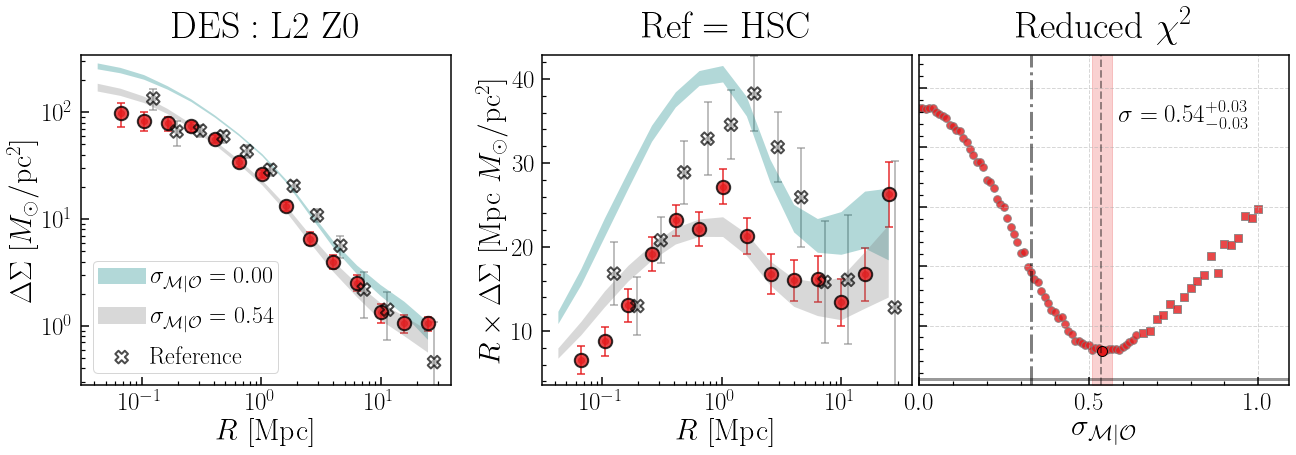

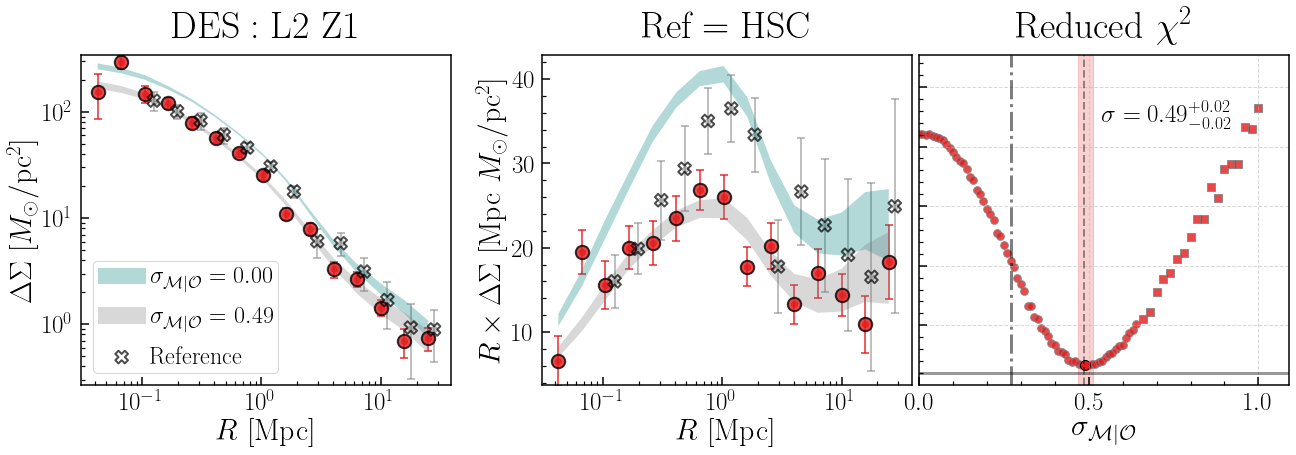

In [225]:
print("# 0.20 < z < 0.35")
des_l2_z0, hsc_l2_z0, fig = prepare_des_dsig(
    'l2_z0', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=45, p_cen=0.0)

print("\n# 0.35 < z < 0.50")
des_l2_z1, hsc_l2_z1, fig = prepare_des_dsig(
    'l2_z1', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=45, p_cen=0.0)

des_sum['des_l2_z0'] = des_l2_z0
des_sum['des_l2_z1'] = des_l2_z1
des_sum['hsc_l2_z0'] = hsc_l2_z0
des_sum['hsc_l2_z1'] = hsc_l2_z1

#### 20 < lambda < 30

# 0.20 < z < 0.35
# The S/N of the DES DSigma profile is  33.97
# There are 67 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  24.97

# 0.35 < z < 0.50
# The S/N of the DES DSigma profile is  26.80
# There are 85 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  20.82


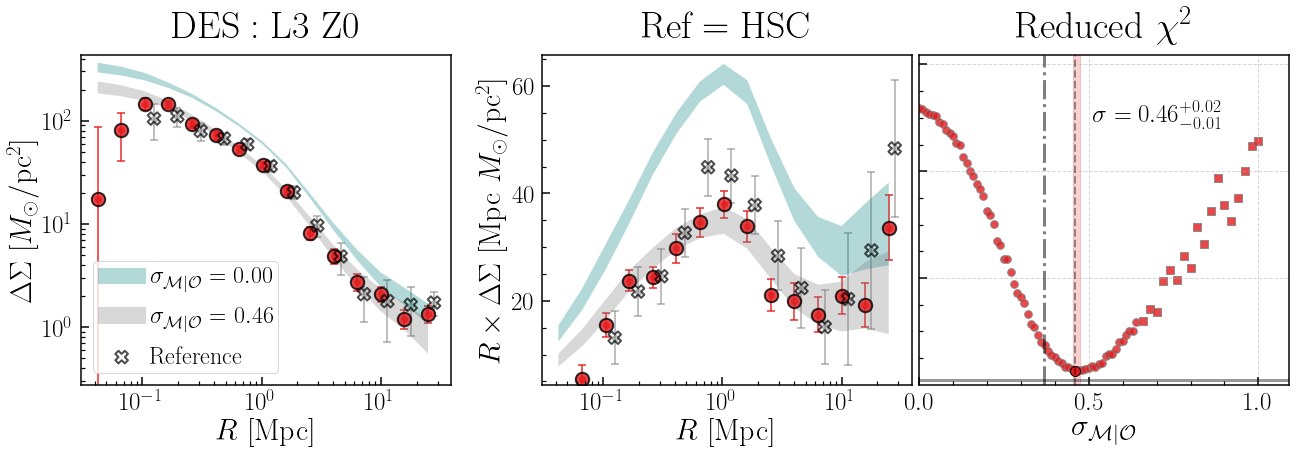

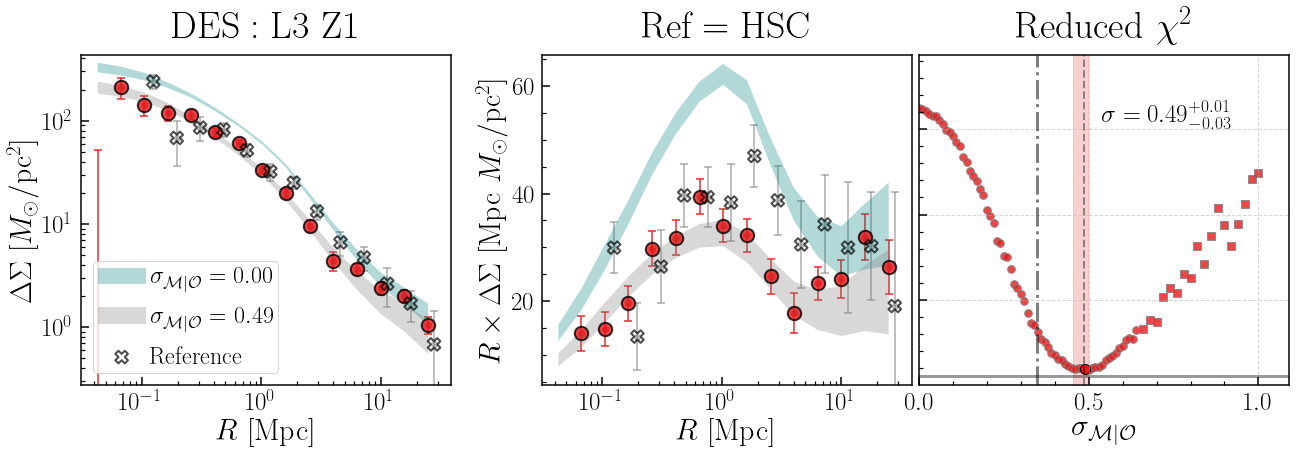

In [226]:
print("# 0.20 < z < 0.35")
des_l3_z0, hsc_l3_z0, fig = prepare_des_dsig(
    'l3_z0', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=45, p_cen=0.0)

print("\n# 0.35 < z < 0.50")
des_l3_z1, hsc_l3_z1, fig = prepare_des_dsig(
    'l3_z1', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=45, p_cen=0.0)

des_sum['des_l3_z0'] = des_l3_z0
des_sum['des_l3_z1'] = des_l3_z1
des_sum['hsc_l3_z0'] = hsc_l3_z0
des_sum['hsc_l3_z1'] = hsc_l3_z1

#### 30 < lambda < 45

# 0.20 < z < 0.35
# The S/N of the DES DSigma profile is  31.97
# There are 19 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  62.08

# 0.35 < z < 0.50
# The S/N of the DES DSigma profile is  32.52
# There are 32 HSC clusters in this bin
# The S/N of the HSC DSigma profile is  21.20


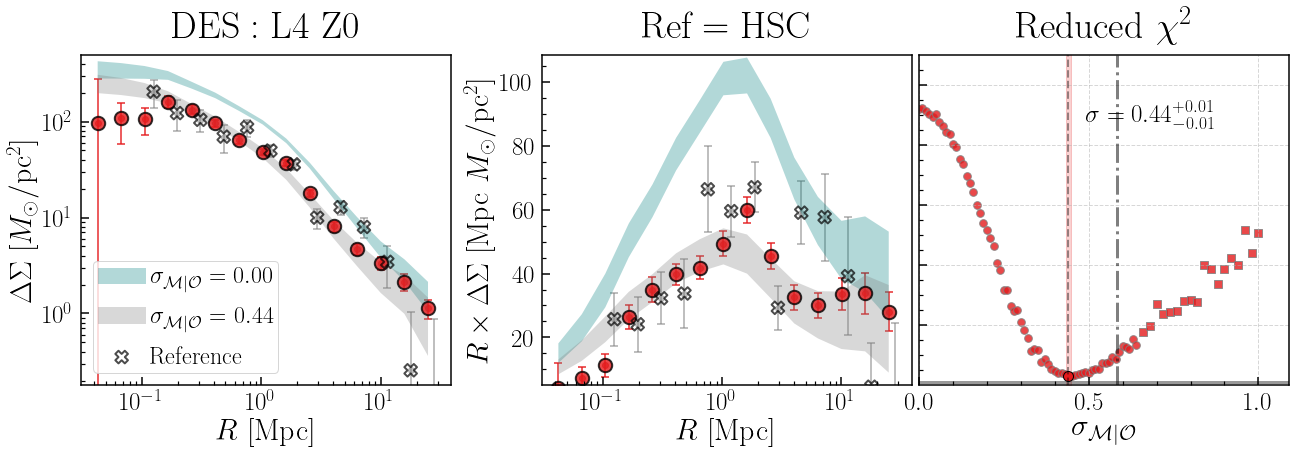

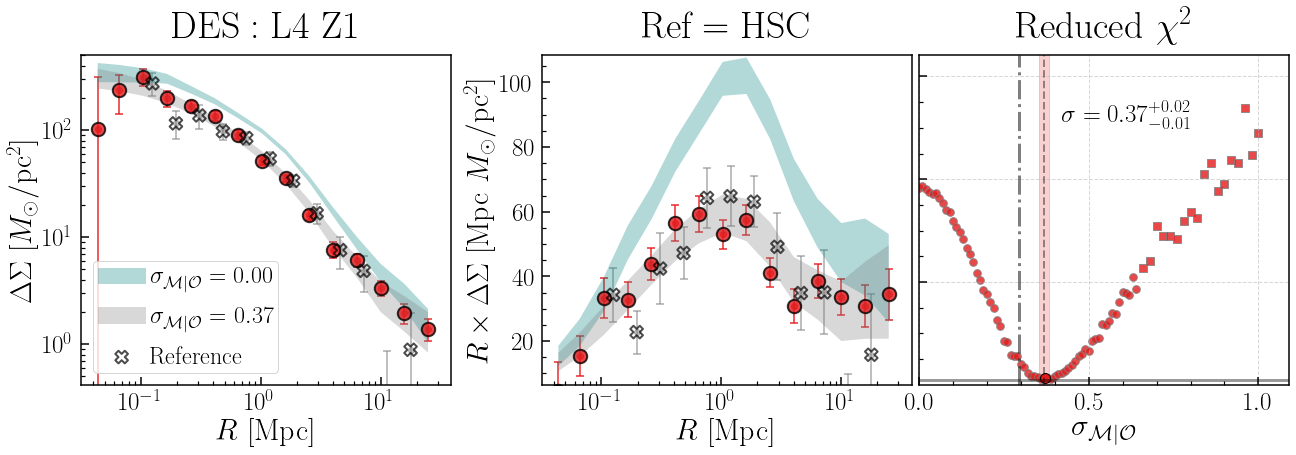

In [247]:
print("# 0.20 < z < 0.35")
des_l4_z0, hsc_l4_z0, fig = prepare_des_dsig(
    'l4_z0', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=40, p_cen=0.0)

print("\n# 0.35 < z < 0.50")
des_l4_z1, hsc_l4_z1, fig = prepare_des_dsig(
    'l4_z1', sim_dsig=sim_dsig, des_dir=des_dir, plot=True, note=r"$\rm Ref = HSC$", 
    hsc=redm_hsc, rand=rand, n_jk=40, p_cen=0.0)

des_sum['des_l4_z0'] = des_l4_z0
des_sum['des_l4_z1'] = des_l4_z1
des_sum['hsc_l4_z0'] = hsc_l4_z0
des_sum['hsc_l4_z1'] = hsc_l4_z1

In [248]:
import pickle

In [250]:
with open(os.path.join(jianbing.JB_DIR, 'data', 'des', 'des_hsc_mcclintock2018_dsigma.p'), 'wb') as handle:
    pickle.dump(des_sum, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [245]:
def prepare_des_dsig(sample, sim_dsig=None, des_dir=des_dir, plot=True, p_cen=0.5,
                     note=r"$\rm Ref = HSC$", hsc=None, rand=None, n_jk=45):
    """"""
    sample_split = sample.split('_')
    l_idx, z_idx = int(sample.split('_')[0][1]), int(sample.split('_')[1][1])
    
    if z_idx == 0:
        z_low, z_upp = 0.2, 0.35
    elif z_idx == 1:
        z_low, z_upp = 0.35, 0.5
    else:
        raise ValueError()
        
    if l_idx == 0:
        l_low, l_upp = 5, 10
        bin_id = 4
    elif l_idx == 1:
        l_low, l_upp = 10, 14
        bin_id = 3
    elif l_idx == 2:
        l_low, l_upp = 14, 20
        bin_id = 3
    elif l_idx == 3:
        l_low, l_upp = 20, 30
        bin_id = 2
    elif l_idx == 4:
        l_low, l_upp = 30, 45
        bin_id = 1
    elif l_idx == 5:
        l_low, l_upp = 45, 60
        bin_id = 1
    elif l_idx == 6:
        l_low, l_upp = 60, 200
        bin_id = 1
        
    des_dsig = Table.read(os.path.join(
        des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_{:s}_profile.dat'.format(sample)), format='ascii')

    des_boost = Table.read(os.path.join(
        des_dir, 'full-unblind-v2-mcal-zmix_y1clust_{:s}_zpdf_boost.dat'.format(sample)), format='ascii')

    des_boost.rename_column('R', 'r_mpc')

    boost_interp = interpolate.interp1d(
        des_boost['r_mpc'], des_boost['1+B(z)'], fill_value='extrapolate')(des_dsig['col1'])

    des_cov = np.loadtxt(os.path.join(
        des_dir, 'full-unblind-v2-mcal-zmix_y1subtr_{:s}_dst_cov.dat'.format(sample)))

    bins = np.logspace(np.log10(0.03), np.log10(30), 16, base=10)

    dsig_sum = {}
    dsig_sum['name'] = sample
    dsig_sum['bin_id'] = bin_id
    dsig_sum['z_low'] = z_low
    dsig_sum['z_upp'] = z_low
    dsig_sum['l_low'] = l_low
    dsig_sum['l_upp'] = l_upp
    dsig_sum['r_mpc'] = des_dsig['col1']
    dsig_sum['dsigma'] = des_dsig['col2'] * boost_interp
    dsig_sum['dsigma_t'] = des_dsig['col2']
    dsig_sum['dsig_err_jk'] = des_dsig['col3']
    dsig_sum['dsig_err_bt'] = des_dsig['col3']
    dsig_sum['dsig_cov_jk'] = des_cov
    dsig_sum['dsig_cov_bt'] = des_cov
    dsig_sum['dsig_s2n_jk'] = np.sqrt(
        np.dot(dsig_sum['dsigma_t'].T.dot(np.linalg.inv(des_cov)), dsig_sum['dsigma_t']))
    dsig_sum['dsig_s2n_bt'] = np.sqrt(
        np.dot(dsig_sum['dsigma_t'].T.dot(np.linalg.inv(des_cov)), dsig_sum['dsigma_t']))
    dsig_sum['dsigma_x'] = des_dsig['col4']
    dsig_sum['dsig_err_x'] = des_dsig['col5']
    dsig_sum['boost'] = boost_interp

    dsig_tab = Table([dsig_sum])
    dsig_tab.meta['r_mpc'] = des_dsig['col1']
    dsig_tab.meta['H0'] = 70.0
    dsig_tab.meta['Om0'] = 0.3
    dsig_tab.meta['Ok0'] = 0.0
    dsig_tab.meta['comoving'] = False
    dsig_tab.meta['bins'] = bins
    dsig_tab.meta['r_min'] = bins[0:-1]
    dsig_tab.meta['r_max'] = bins[1:]
    
    print("# The S/N of the DES DSigma profile is {:6.2f}".format(dsig_sum['dsig_s2n_jk']))

    if sim_dsig is not None:
        dsig_sum = scatter.compare_model_dsigma(
            dsig_tab, sim_dsig, model_err=False, poly=True, verbose=False)
        if plot:
            if hsc is not None and rand is not None:
                hsc_mask = (
                    (hsc['z'] >= z_low) & (hsc['z'] < z_upp) &
                    (hsc['lambda'] >= l_low) & (hsc['lambda'] < l_upp))
                
                print("# There are {:d} HSC clusters in this bin".format(hsc_mask.sum()))

                hsc_dsig = wlensing.batch_dsigma_profiles(
                    hsc, rand, [hsc_mask], n_rand=100000, n_boot=500, n_jk=n_jk, 
                    verbose=False, n_jobs=None)

                hsc_dsig['bin_id'] = bin_id
                hsc_dsig['n_obj'] = hsc_mask.sum()

                hsc_sum = scatter.compare_model_dsigma(
                    hsc_dsig, sim_dsig, model_err=False, poly=True, verbose=False)

                print("# The S/N of the HSC DSigma profile is {:6.2f}".format(hsc_sum['dsig_s2n_jk'][0]))
            else:
                hsc_sum=None
            
            fig = visual.sum_plot_topn(
                dsig_sum, r'$\rm DES:{:s}$'.format(sample.replace("_", "\ ").upper()), 
                note=note, show_bin=False, cov_type='jk', ref_tab=hsc_sum)
            return dsig_sum, hsc_sum, fig
        return dsig_sum
    return dsig_tab